In [88]:
import os
import random
import numpy as np
import tensorflow as tf
import time

from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import keras.optimizers

In [89]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 512  # Number of images used in each iteration
    EPOCHS = 12  # Number of passes through entire dataset
    
# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 64
    EPOCHS = 12


In [90]:
#################
# Configuration #
#################

# dictionary of languages that our classifier will cover
LANGUAGES_DICT = {'BEI':0,'MSA':1,'CAI':2,'DOH':3,'RAB':4,'TUN':5}

# Length of cleaned text used for training and prediction - 140 chars
MAX_LEN = 250

# number of language samples per language that we will extract from source files
NUM_SAMPLES = 9000

# For reproducibility
SEED = 42

import support #import define_alphabet
# Load the Alphabet
alphabet = support.define_alphabet()
print('ALPHABET:')
print(alphabet[1])

VOCAB_SIZE = len(alphabet[1])
print('ALPHABET LEN(VOCAB SIZE):', VOCAB_SIZE)

# Folders from where load / store the raw, source, cleaned, samples and train_test data
data_directory = "../data/Dialect6"
source_directory = os.path.join(data_directory, 'source')
cleaned_directory = os.path.join(data_directory, 'cleaned')
samples_directory = os.path.join('/tmp', 'samples')
cleaned_directory_test =os.path.join(data_directory, 'cleaned_test')
train_test_directory = os.path.join('/tmp', 'train_test')

ALPHABET:
ءآأؤإئابةتثجحخدذرزسشصضطظعغفقكلمنهوىي ؟!?¿¡
ALPHABET LEN(VOCAB SIZE): 42


In [91]:
from support import get_sample_text, get_input_row
    
# let's see if our processing is returning counts
# last part calculates also input_size for DNN so this code must be run before DNN is trained
path = os.path.join(cleaned_directory, "BEI_clean.txt")
with open(path, 'r') as f:
    content = f.read()
    random_index = random.randrange(0,len(content)-2*MAX_LEN)
    sample_text = get_sample_text(content,random_index,MAX_LEN)
    print ("1. SAMPLE TEXT: \n", sample_text)
    print ("\n2. REFERENCE ALPHABET: \n", alphabet[0])
    
    sample_input_row = get_input_row(content, random_index, MAX_LEN, alphabet)
    print ("\n3. SAMPLE INPUT ROW: \n",sample_input_row)
    
    input_size = len(sample_input_row)
    if input_size != VOCAB_SIZE:
        print("Something strange happened!")
        
    print ("\n4. INPUT SIZE (VOCAB SIZE): ", input_size)
    del content

1. SAMPLE TEXT: 
 اي بريد لالي ؟
 بدي إسحب أربعمية دولار من حسابي
 عندك منبه للسفر ؟
 لا بس فيك تدق عهالرقم للمساعدة اليابانية الف و تمنمية
 وين اقرب خياط ؟
 مرحبا هيدي الأوضة تلاتة صفر خمسة
 رح فل بكير بكرا الصبح
 مليان لاء يسلمو
 إذا بتريد فرجيني كفوف
 هيدا الباقي

2. REFERENCE ALPHABET: 
 ['ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي', ' ', '؟', '!', '?', '¿', '¡']

3. SAMPLE INPUT ROW: 
 [1, 0, 2, 0, 2, 0, 24, 15, 7, 5, 0, 1, 5, 2, 9, 1, 13, 0, 7, 0, 2, 1, 1, 0, 4, 0, 8, 4, 5, 19, 11, 8, 4, 6, 0, 22, 47, 3, 0, 0, 0, 0]

4. INPUT SIZE (VOCAB SIZE):  42


In [92]:
# Utility function to return file Bytes size in MB
def size_mb(size):
    size_mb =  '{:.2f}'.format(size/(1000*1000.0))
    return size_mb + " MB"

# Now we have preprocessing utility functions ready. Let's use them to process each cleaned language file
# and turn text data into numerical data samples for our neural network
# prepare numpy array
sample_data = np.empty((NUM_SAMPLES*len(LANGUAGES_DICT),input_size+1),dtype = np.uint16)
lang_seq = 0 # offset for each language data
jump_reduce = 0.2 # part of characters removed from jump to avoid passing the end of file

for lang_code in LANGUAGES_DICT:
    start_index = 0
    path = os.path.join(cleaned_directory, lang_code+"_clean.txt")
    with open(path, 'r') as f:
        print ("Processing file : " + path)
        file_content = f.read()
        content_length = len(file_content)
        print(content_length)
        remaining = content_length - MAX_LEN*NUM_SAMPLES
        jump = int(((remaining/NUM_SAMPLES)*3)/4)
        print ("File size : ",size_mb(content_length),\
               " | # possible samples : ",int(content_length/VOCAB_SIZE),\
              "| # skip chars : " + str(jump))
        for idx in range(NUM_SAMPLES):
            if (content_length-start_index < 300):
                break
            input_row = get_input_row(file_content, start_index, MAX_LEN, alphabet)
            #print(idx,' ',start_index,' ',MAX_LEN)
            sample_data[NUM_SAMPLES*lang_seq+idx,] = input_row + [LANGUAGES_DICT[lang_code]]
            start_index += MAX_LEN + jump
        del file_content
    lang_seq += 1
    print (100*"-")
     
# Let's randomy shuffle the data
np.random.shuffle(sample_data)
# reference input size
print ("Vocab Size : ",VOCAB_SIZE )
print (100*"-")
print ("Samples array size : ",sample_data.shape )

# Create the the sample dirctory if not exists
if not os.path.exists(samples_directory):
    os.makedirs(samples_directory)

# Save compressed sample data to disk
path_smpl = os.path.join(samples_directory,"lang_samples_"+str(VOCAB_SIZE)+".npz")
np.savez_compressed(path_smpl,data=sample_data)
print(path_smpl, "size : ", size_mb(os.path.getsize(path_smpl)))
del sample_data

Processing file : ../data/Dialect6/cleaned/BEI_clean.txt
267225
File size :  0.27 MB  | # possible samples :  6362 | # skip chars : -165
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect6/cleaned/MSA_clean.txt
322546
File size :  0.32 MB  | # possible samples :  7679 | # skip chars : -160
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect6/cleaned/CAI_clean.txt
288771
File size :  0.29 MB  | # possible samples :  6875 | # skip chars : -163
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect6/cleaned/DOH_clean.txt
263868
File size :  0.26 MB  | # possible samples :  6282 | # skip chars : -165
----------------------------------------------------------------------------------------------------
Processing file : ../data/Dialect6/cleaned/RAB_c

In [93]:
# utility function to turn language id into language code
def decode_langid(langid):    
    for dname, did in LANGUAGES_DICT.items():
        if did == langid:
            return dname

# Loading the data
path_smpl = os.path.join(samples_directory,"lang_samples_"+str(VOCAB_SIZE)+".npz")
dt = np.load(path_smpl)['data']

# Sanity chech on a random sample
random_index = random.randrange(0,dt.shape[0])
print ("Sample record : \n",dt[random_index,])
print ("\nSample language : ",decode_langid(dt[random_index,][VOCAB_SIZE]))

# Check if the data have equal share of different languages
print ("\nDataset shape (Total_samples, Alphabet):", dt.shape)
bins = np.bincount(dt[:,input_size])

print ("Language bins count (samples per language): ") 
for lang_code in LANGUAGES_DICT: 
    print (lang_code, bins[LANGUAGES_DICT[lang_code]])

Sample record : 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]

Sample language :  BEI

Dataset shape (Total_samples, Alphabet): (54000, 43)
Language bins count (samples per language): 
BEI 37317
MSA 3581
CAI 3316
DOH 3101
RAB 3474
TUN 3211


In [94]:
# we need to preprocess data for DNN yet again - scale it 
# scaling will ensure that our optimization algorithm (variation of gradient descent) will converge well
# we need also ensure one-hot econding of target classes for softmax output layer
# let's convert datatype before processing to float
dt = dt.astype(np.float32)
# X and Y split
X = dt[:, 0:input_size] # Samples
Y = dt[:, input_size] # The last element is the label
print(set(Y))
del dt

# Random index to check random sample
random_index = random.randrange(0,X.shape[0])
print("Example data before processing:")
print("X : \n", X[random_index,])
print("Y : \n", Y[random_index])

# X PREPROCESSING
# Feature Standardization - Standar scaler will be useful later during DNN prediction
standard_scaler = preprocessing.StandardScaler().fit(X)
X = standard_scaler.transform(X)   
print ("X preprocessed shape :", X.shape)

# Y PREPROCESSINGY 
# One-hot encoding
Y = keras.utils.to_categorical(Y, num_classes=len(LANGUAGES_DICT))

# See the sample data
print("\nExample data after processing:")
print("X : \n", X[random_index,])
print("Y : \n", Y[random_index])

# Train/test split. Static seed to have comparable results for different runs
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=SEED)
del X, Y

# Create the train / test directory if not extists
if not os.path.exists(train_test_directory):
    os.makedirs(train_test_directory)

# Save compressed train_test data to disk
path_tt = os.path.join(train_test_directory,"train_test_data_"+str(VOCAB_SIZE)+".npz")
np.savez_compressed(path_tt,X_train=X_train,Y_train=Y_train,X_test=X_test,Y_test=Y_test)
print(path_tt, "size : ",size_mb(os.path.getsize(path_tt)))
del X_train,Y_train,X_test,Y_test


{0.0, 1.0, 2.0, 3.0, 4.0, 5.0}
Example data before processing:
X : 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Y : 
 0.0
X preprocessed shape : (54000, 42)

Example data after processing:
X : 
 [-0.24221979 -0.24860772 -0.48550162 -0.12504515 -0.4181301  -0.26915985
 -0.7341229  -0.67903733 -0.6517166  -0.7018764  -0.29948145 -0.5942327
 -0.64835864 -0.57450163 -0.6722118  -0.4332265  -0.70607066 -0.5156877
 -0.6497483  -0.60545516 -0.5497367  -0.45817655 -0.57991594 -0.2493815
 -0.6792949  -0.47389525 -0.6678122  -0.620151   -0.68789846 -0.7287956
 -0.71236247 -0.71702695 -0.6351807  -0.6997902  -0.44042534 -0.731145
 -0.7598836  -0.6556906   0.          0.          0.          0.        ]
Y : 
 [1. 0. 0. 0. 0. 0.]
/tmp/train_test/train_test_data_42.npz size :  0.97 MB


In [80]:

# Load train data first from file
path_tt = os.path.join(train_test_directory, "train_test_data_"+str(VOCAB_SIZE)+".npz")
train_test_data = np.load(path_tt)

# Train Set
X_train = train_test_data['X_train']
print ("X_train: ",X_train.shape)
Y_train = train_test_data['Y_train']
print ("Y_train: ",Y_train.shape)

# Test Set
X_test = train_test_data['X_test']
print ("X_test: ",X_test.shape)
Y_test = train_test_data['Y_test']
print ("Y_test: ",Y_test.shape)

del train_test_data

X_train:  (43200, 42)
Y_train:  (43200, 6)
X_test:  (10800, 42)
Y_test:  (10800, 6)


In [81]:

model = Sequential()
# Note: glorot_uniform is the Xavier uniform initializer.

model.add(Dense(500,input_dim=input_size, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(300, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(100, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(len(LANGUAGES_DICT), kernel_initializer="glorot_uniform", activation="softmax"))
model_optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 500)               21500     
_________________________________________________________________
dropout_10 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 300)               150300    
_________________________________________________________________
dropout_11 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               30100     
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 606       
Total para

In [82]:
from keras.callbacks import TensorBoard

# Tensorboard
tensorboard = TensorBoard(log_dir="run")

# let's fit the data
# history variable will help us to plot results later
history = model.fit(X_train,Y_train,
                  epochs=EPOCHS,
                  validation_split=0.1,
                  batch_size=BATCH_SIZE,
                  callbacks=[tensorboard],
                  shuffle=True,
                  verbose=2)

Train on 38880 samples, validate on 4320 samples
Epoch 1/12
 - 3s - loss: 0.5558 - acc: 0.7899 - val_loss: 0.2367 - val_acc: 0.9178
Epoch 2/12
 - 3s - loss: 0.2217 - acc: 0.9229 - val_loss: 0.1321 - val_acc: 0.9544
Epoch 3/12
 - 3s - loss: 0.1692 - acc: 0.9421 - val_loss: 0.1243 - val_acc: 0.9558
Epoch 4/12
 - 3s - loss: 0.1546 - acc: 0.9486 - val_loss: 0.1188 - val_acc: 0.9590
Epoch 5/12
 - 3s - loss: 0.1391 - acc: 0.9543 - val_loss: 0.1097 - val_acc: 0.9611
Epoch 6/12
 - 3s - loss: 0.1350 - acc: 0.9550 - val_loss: 0.1098 - val_acc: 0.9630
Epoch 7/12
 - 3s - loss: 0.1306 - acc: 0.9562 - val_loss: 0.1074 - val_acc: 0.9618
Epoch 8/12
 - 3s - loss: 0.1287 - acc: 0.9558 - val_loss: 0.1087 - val_acc: 0.9604
Epoch 9/12
 - 3s - loss: 0.1278 - acc: 0.9564 - val_loss: 0.1034 - val_acc: 0.9637
Epoch 10/12
 - 3s - loss: 0.1244 - acc: 0.9574 - val_loss: 0.1032 - val_acc: 0.9630
Epoch 11/12
 - 3s - loss: 0.1215 - acc: 0.9582 - val_loss: 0.1026 - val_acc: 0.9625
Epoch 12/12
 - 3s - loss: 0.1203 - a

In [83]:
scores = model.evaluate(X_test, Y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

10800/10800 [==============================] - 0s 45us/step
acc: 96.06%


In [84]:

# and now we will prepare data for scikit-learn confusion matrix and classification report
Y_pred = model.predict_classes(X_test)
Y_pred = keras.utils.to_categorical(Y_pred, num_classes=len(LANGUAGES_DICT))
LABELS =  list(LANGUAGES_DICT.keys())

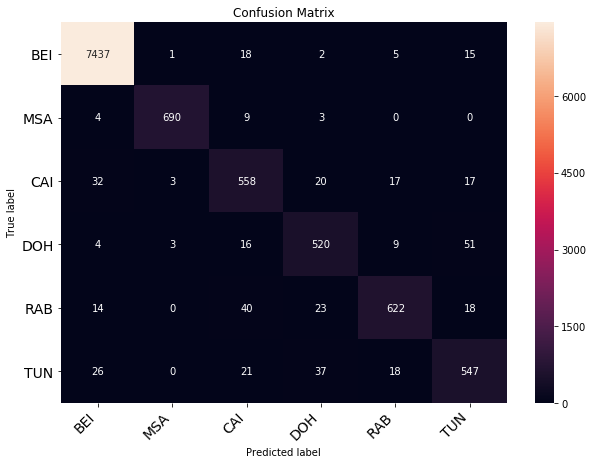

In [85]:

# Plot confusion matrix 
from sklearn.metrics import confusion_matrix
from support import print_confusion_matrix

cnf_matrix = confusion_matrix(np.argmax(Y_pred,axis=1), np.argmax(Y_test,axis=1))
_ = print_confusion_matrix(cnf_matrix, LABELS)

In [87]:
from ipywidgets import interact_manual
from ipywidgets import widgets
from support import clean_text


def get_prediction(TEXT):
    if len(TEXT) < MAX_LEN:
        print("Text has to be at least {} chars long, but it is {}/{}".format(MAX_LEN, len(TEXT), MAX_LEN))
        return(-1)
    # Data cleaning
    print(" it is {}/{}".format(len(TEXT), MAX_LEN))
    cleaned_text = clean_text(TEXT)
    
    # Get the MAX_LEN char
    input_row = get_input_row(cleaned_text, 0, MAX_LEN, alphabet)
    
    # Data preprocessing (Standardization)
    test_array = standard_scaler.transform([input_row])
    
    raw_score = model.predict(test_array)
    pred_idx= np.argmax(raw_score, axis=1)[0]
    score = raw_score[0][pred_idx]*100
    
    # Prediction
    prediction = LABELS[model.predict_classes(test_array)[0]]
    print('TEXT:', TEXT, '\nPREDICTION:', prediction.upper(), '\nSCORE:', score)

interact_manual(get_prediction, TEXT=widgets.Textarea(placeholder='ازيك عامل ايه انا سألت عنك كتير اوي'));

interactive(children=(Textarea(value='', description='TEXT', placeholder='ازيك عامل ايه انا سألت عنك كتير اوي'…